### CONFIGURATION

In [350]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [351]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [352]:
#CHROM SLICING
minChromFrac = 0
maxChromFrac = 26

In [353]:
# BED FILE
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/70-30mixin/"
BED_FILE_NAME = "na12878-na24385-somatic-truth-regions.bed"

# TRUTH SET
SAMPLE_NAMES_TRUTH = {'NA12878':'70-30truth'}
VCF_PATH_TRUTH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/70-30mixin/"
VCF_FILE_NAME_TRUTH = "na12878-na24385-somatic-truth.vcf"

# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT11111111"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/70-30sample/161103_GIAB_mixin_reference_run_v1.10/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somatics.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}

### Functions

In [354]:
def filterByChromFrac(df):
    return df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]

In [355]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] = False
    df['hasFP'] = False
    for columnName in list(df):
        if columnName.endswith('allele') and not columnName.startswith('truth'):
            df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truth_indelDiff']) \
                    & (~pd.isnull(df['truth_indelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truth_allele']) \
                    & (df['variantType'] == 'SNP'))
            df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truth_indelDiff']) \
                    & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')& (~pd.isnull(df['truth_allele']))) |((df[columnName] != df['truth_allele']) \
                    & (df['variantType'] == 'SNP') & (df[columnName] != '')& (~pd.isnull(df['truth_allele'])))
    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
    return df

In [356]:
def calcuatePrecisionSensivityMatrix(df):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('_allele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = len(dfTruth[dfTruth['variantType'] == variantType]) 
                falseNegatives = truthSet - truePositives
                if positives > 0 and truthSet > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

<h3> Load VCFs and Prepare DF

In [357]:
## LOAD BED
bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
cum_sum =0
for row in bed:
    cum_sum += -int(row[1]) + int(row[2])
print cum_sum

reading BED file
Bed File Loaded
2333895411


In [358]:
## LOAD TRUTH SET VCF
truthBed = copy.deepcopy(bed)
dfTruth = aVCF.loadVaraintsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH, \
                                   SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True,True,truthBed)
dfTruth = filterByChromFrac(dfTruth)
dfTruth.rename(columns={'70-30truthallele':'truth_allele','70-30truthindelDiff':'truth_indelDiff','70-30truthindelPos':'truth_indelPos'}, inplace=True)
dfTruth = dfTruth[['chrom','pos','variantType','ref','truth_allele','truth_indelDiff','truth_indelPos']]
dfTruth = dfTruth.set_index(['chrom','pos'])

reading vcf file: na12878-na24385-somatic-truth.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
reading VCF File line: 1100000
Number variants loaded: 1101868


In [359]:
# LOAD SAMPLE VCF + match to truth set
sampleBed = copy.deepcopy(bed)
dfProd = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True,True,sampleBed)
dfProd = filterByChromFrac(dfProd)
dfProd = dfProd.set_index(['chrom','pos'])
dfProd = calculateTruth(dfProd,dfTruth)

reading vcf file: CPCT11111111R_CPCT11111111T_merged_somatics.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
reading VCF File line: 900000
reading VCF File line: 1000000
reading VCF File line: 1100000
reading VCF File line: 1200000
reading VCF File line: 1300000
reading VCF File line: 1400000
Number variants loaded: 1077347


### PRECISION + SENSITIVITY|

In [360]:
outputDF = calcuatePrecisionSensivityMatrix(dfProd)
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,96385,64192,692,32193,0.9893,0.6660
1,INDEL,strelka,96385,48251,272,48134,0.9944,0.5006
3,INDEL,varscan,96385,63411,619,32974,0.9903,0.6579
5,SNP,freebayes,1005483,933292,997,72191,0.9989,0.9282
4,SNP,mutect,1005483,929772,5904,75711,0.9937,0.9247
0,SNP,strelka,1005483,939193,3505,66290,0.9963,0.9341
2,SNP,varscan,1005483,897461,826,108022,0.9991,0.8926


In [361]:
dftemp = dfProd.reset_index()
pd.pivot_table(dftemp, values='pos', index=['variantType','numCallers'], columns=['Truth'], aggfunc='count')

Truth                    False     True 
variantType numCallers                  
INDEL       1           1089.0   12289.0
            2            205.0   17827.0
            3             28.0   42637.0
MIXED       2             36.0       NaN
SNP         1           7421.0   23817.0
            2           1579.0   56689.0
            3            147.0   91597.0
            4             53.0  821933.0

<h3> SNP

In [310]:
snpdf = dfProd[(dfProd.variantType == 'SNP')]

In [ ]:
snpdf[['Truth','pos']].groupby(['Truth']).agg('count')

In [ ]:
pd.pivot_table(snpdf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [ ]:
indeldf= dfProd[(dfProd.variantType == 'INDEL')]

In [ ]:
pd.pivot_table(indeldf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

<h3> Allelic Depth

freebayesAF


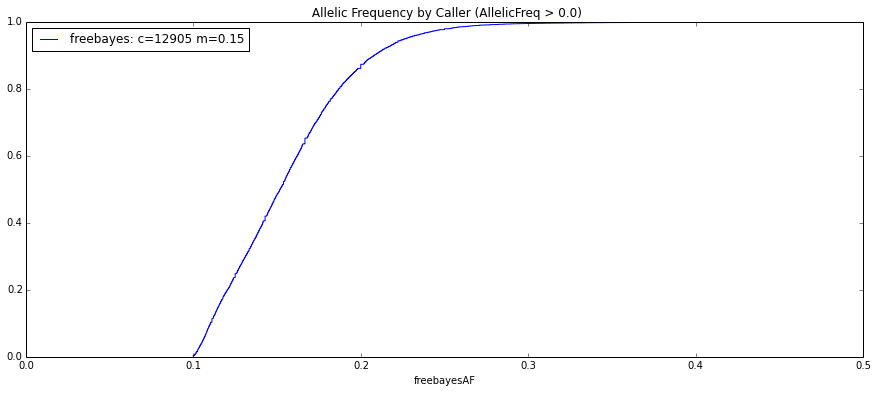

In [335]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('freebayesAF'):
        print columnName
        ser = snpdf[(snpdf.Truth == False)][columnName[:-2] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-2]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6],xlim=[0,0.5])

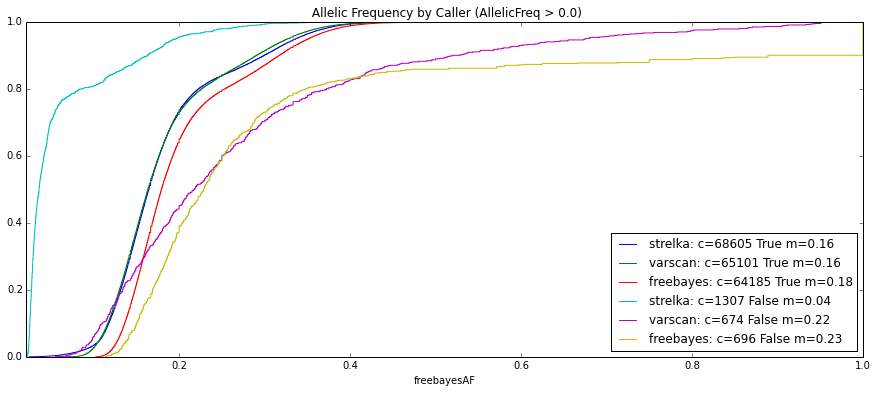

In [289]:
snpdf = dfProd[(dfProd.variantType == 'INDEL')]
truths = [True,False]
for truth in truths:
    #Alllele Freq By Caller
    for columnName in list(snpdf):
        if columnName.endswith('AF') and not columnName.endswith('tAF'):
            ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-2] + 'AF'] > 0.0) \
                    &(snpdf.Truth == truth)][columnName[:-2] + 'AF']
            ser = ser.sort_values()
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-2]+": c="+str(ser.count())+ " "+ str(truth) +" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")